<a href="https://colab.research.google.com/github/mahmoodtt1/OR/blob/main/Streetcar_7_16_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import re
import pandas as pd

def extract_downtown_runs(df_raw):
    runs = []
    current_run = []
    collecting = False

    for _, row in df_raw.iterrows():
        if str(row[1]).strip() == "Station Stop":
            if current_run:
                runs.append(pd.DataFrame(current_run))
                current_run = []
            collecting = True
            current_run.append(row)
        elif collecting:
            current_run.append(row)

    if current_run:
        runs.append(pd.DataFrame(current_run))
    return runs

def extract_date_from_filename(filename):
    # Match formats like "May 27 2025" or "27 5 2025"
    match = re.search(r"(\d{1,2})\s+(\d{1,2})\s+(\d{4})", filename)
    if match:
        day = int(match.group(1))
        month = int(match.group(2))
        year = int(match.group(3))
        return f"{month:02d}-{day:02d}-{year}"
    return "UnknownDate"

def read_cleaned_downtown_data(folder_path):
    all_runs = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".xls") or filename.endswith(".xlsm"):
            file_path = os.path.join(folder_path, filename)
            try:
                xls = pd.ExcelFile(file_path)
                if "Downtown Data" in xls.sheet_names:
                    df_raw = xls.parse("Downtown Data", header=None)
                    runs = extract_downtown_runs(df_raw)
                    file_date = extract_date_from_filename(filename)

                    for i, run_df in enumerate(runs):
                        run_df = run_df.reset_index(drop=True)

                        # Extract only necessary columns by index
                        cols_to_extract = [2, 7, 8, 9]  # Intersection, Arrive, Depart, TSP
                        run_clean = run_df.iloc[:, cols_to_extract].copy()
                        run_clean.columns = ["Intersection", "Arrive", "Depart", "TSP Type"]

                        # Add metadata
                        run_clean["Date"] = file_date
                        run_clean["RunID"] = f"{file_date}_Run{i+1}"
                        run_clean["File"] = filename

                        all_runs.append(run_clean)

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if all_runs:
        return pd.concat(all_runs, ignore_index=True)
    else:
        return pd.DataFrame(columns=["Intersection", "Arrive", "Depart", "TSP Type", "Date", "RunID", "File"])


In [10]:

folder_path = "/content/drive/My Drive/Colab Notebooks/tsp_data"
df3 = read_cleaned_downtown_data(folder_path)

# Optional: preview
df3.head()

,Intersection,Arrive,Depart,TSP Type,Date,RunID,File
0,Union Station (Pershing & Main),NaN,11:46:21,Opticom,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...
1,Union Station Crosswalk,11:46:32,11:46:35,NaN,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...
2,20th St. & Main,11:47:29,11:47:40,NaN,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...
3,19th St. & Main,11:48:05,11:48:08,NaN,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...
4,Crossroads (19th & Main) NB,11:48:20,11:48:38,NaN,27-05-2025,27-05-2025_Run2,Running Time Data for ONLY OPTICOM Mahmood 5 2...


In [11]:
df3.tail()

,Intersection,Arrive,Depart,TSP Type,Date,RunID,File
4885,20th St. & Main,NaN,NaN,NaN,15-07-2025,15-07-2025_Run101,Running Time Data for TSP 7 15 2025.xlsm
4886,Union Station Crosswalk,NaN,NaN,NaN,15-07-2025,15-07-2025_Run101,Running Time Data for TSP 7 15 2025.xlsm
4887,Union Station (Pershing & Main),NaN,NaN,NaN,15-07-2025,15-07-2025_Run102,Running Time Data for TSP 7 15 2025.xlsm
4888,NaN,NaN,NaN,NaN,15-07-2025,15-07-2025_Run102,Running Time Data for TSP 7 15 2025.xlsm
4889,NaN,NaN,NaN,NaN,15-07-2025,15-07-2025_Run102,Running Time Data for TSP 7 15 2025.xlsm


In [12]:
df3["TSP Type"].unique()


array(['Opticom', nan, 'Vontas'], dtype=object)

In [13]:
# Remove rows where both Arrive and Depart are NaN
df_cleaned = df3.dropna(subset=["Arrive", "Depart"], how='all').copy()

# Fill missing Arrive with Depart where Arrive is missing
df_cleaned["Arrive"] = df_cleaned["Arrive"].fillna(df_cleaned["Depart"])

# Fill missing Depart with Arrive where Depart is missing
df_cleaned["Depart"] = df_cleaned["Depart"].fillna(df_cleaned["Arrive"])


In [14]:
df_cleaned_cycle = df_cleaned.reset_index(drop=True)  # ensure index is clean
loop_marker = "Union Station Crosswalk"
current_run = 1
loop_count = 0
run_cycles = []

for _, row in df_cleaned.iterrows():
    if row["Intersection"] == loop_marker:
        loop_count += 1
        if loop_count > 1 and loop_count % 2 == 1:  # every 2nd time is a new run start
            current_run += 1
    run_cycles.append(current_run)

df_cleaned["RunCycle"] = run_cycles


In [15]:
df_cleaned.head()

,Intersection,Arrive,Depart,TSP Type,Date,RunID,File,RunCycle
0,Union Station (Pershing & Main),11:46:21,11:46:21,Opticom,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...,1
1,Union Station Crosswalk,11:46:32,11:46:35,NaN,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...,1
2,20th St. & Main,11:47:29,11:47:40,NaN,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...,1
3,19th St. & Main,11:48:05,11:48:08,NaN,27-05-2025,27-05-2025_Run1,Running Time Data for ONLY OPTICOM Mahmood 5 2...,1
4,Crossroads (19th & Main) NB,11:48:20,11:48:38,NaN,27-05-2025,27-05-2025_Run2,Running Time Data for ONLY OPTICOM Mahmood 5 2...,1


In [16]:
from datetime import time, timedelta

# Convert datetime.time to timedelta since midnight
def time_to_timedelta(t):
    if pd.isna(t):
        return pd.NaT
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

# Apply conversion to columns
df_cleaned["Arrive"] = df_cleaned["Arrive"].apply(time_to_timedelta)
df_cleaned["Depart"] = df_cleaned["Depart"].apply(time_to_timedelta)


In [17]:
import pandas as pd

# Rename columns if needed
df_cleaned = df_cleaned.rename(columns={"Arrive": "ArrivalTime", "Depart": "DepartureTime"})

# Ensure time columns are in timedelta format
df_cleaned["ArrivalTime"] = pd.to_timedelta(df_cleaned["ArrivalTime"])
df_cleaned["DepartureTime"] = pd.to_timedelta(df_cleaned["DepartureTime"])

# Define markers
loop_marker = "Union Station Crosswalk"
halfway_marker = "River Market North (Grand & 3rd St.)"

# Extract summary for each RunCycle
cycle_summary_rows = []

for cycle_id, group in df_cleaned.groupby("RunCycle"):
    group = group.reset_index(drop=True)

    union_rows = group[group["Intersection"] == loop_marker]
    if len(union_rows) < 2:
        continue

    start_time = union_rows.iloc[0]["DepartureTime"]
    end_time = union_rows.iloc[-1]["ArrivalTime"]

    halfway_rows = group[group["Intersection"] == halfway_marker]
    half_time = halfway_rows.iloc[0]["ArrivalTime"] if not halfway_rows.empty else pd.NaT

    first_half = half_time - start_time if pd.notna(half_time) else pd.NaT
    second_half = end_time - half_time if pd.notna(half_time) else pd.NaT
    full_cycle = end_time - start_time

    date = group["Date"].iloc[0]

    cycle_summary_rows.append({
        "RunCycle": cycle_id,
        "Date": date,
        "StartTime": start_time,
        "HalfTime": half_time,
        "EndTime": end_time,
        "FirstHalfDuration": first_half,
        "SecondHalfDuration": second_half,
        "FullCycleDuration": full_cycle
    })

# Final DataFrame
df_cycle_summary = pd.DataFrame(cycle_summary_rows)

pd.set_option("display.max_rows", None)

def format_timedelta(td):
    if pd.isna(td):
        return ""
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Columns to format
time_columns = [
    "StartTime", "HalfTime", "EndTime",
    "FirstHalfDuration", "SecondHalfDuration", "FullCycleDuration"
]

# Apply formatting
for col in time_columns:
    df_cycle_summary[col] = df_cycle_summary[col].apply(format_timedelta)


df_cycle_summary

,RunCycle,Date,StartTime,HalfTime,EndTime,FirstHalfDuration,SecondHalfDuration,FullCycleDuration
0,1,27-05-2025,11:46:35,11:59:57,12:11:50,00:13:22,00:11:53,00:25:15
1,2,27-05-2025,12:25:57,12:40:23,12:53:08,00:14:26,00:12:45,00:27:11
2,3,27-05-2025,13:05:59,13:19:40,13:33:42,00:13:41,00:14:02,00:27:43
3,4,27-05-2025,13:46:07,14:00:04,14:12:15,00:13:57,00:12:11,00:26:08
4,5,UnknownDate,09:51:47,10:06:19,10:19:00,00:14:32,00:12:41,00:27:13
5,6,UnknownDate,10:25:29,10:40:30,10:53:21,00:15:01,00:12:51,00:27:52
6,7,UnknownDate,11:19:35,11:34:22,11:53:38,00:14:47,00:19:16,00:34:03
7,8,UnknownDate,12:05:55,12:21:59,12:35:28,00:16:04,00:13:29,00:29:33
8,9,29-05-2025,08:28:17,08:42:37,08:56:25,00:14:20,00:13:48,00:28:08
9,10,29-05-2025,09:08:12,09:31:20,09:45:45,00:23:08,00:14:25,00:37:33


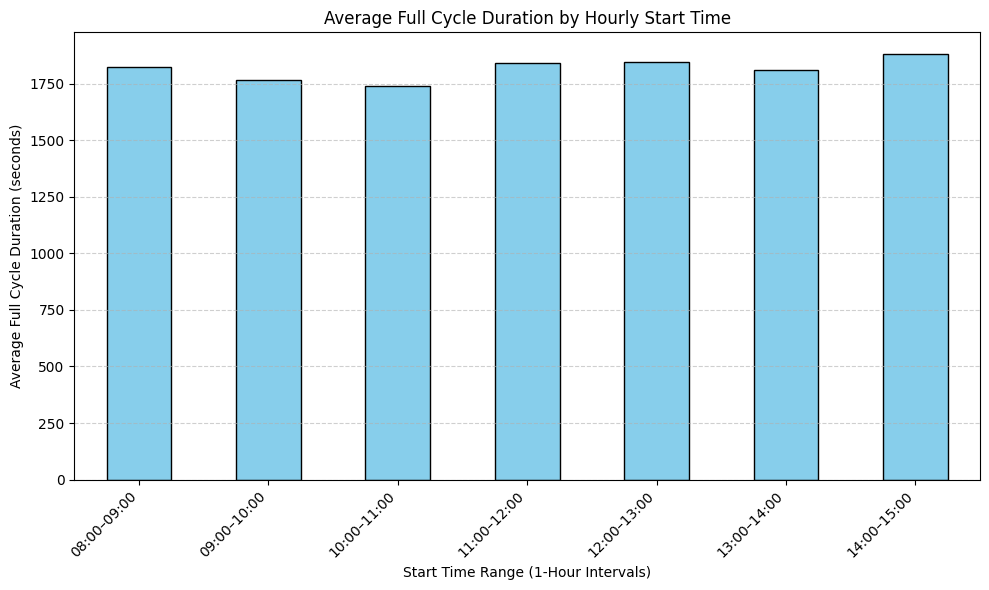

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert time strings to timedeltas if not already
df_cycle_summary["_StartTimeTD"] = pd.to_timedelta(df_cycle_summary["StartTime"])
df_cycle_summary["_FullCycleTD"] = pd.to_timedelta(df_cycle_summary["FullCycleDuration"])

# Define 1-hour bin labels
def classify_hour_bin(td):
    if pd.isna(td):
        return "Unknown"
    hour = int(td.total_seconds() // 3600)
    return f"{hour:02d}:00–{hour+1:02d}:00"

df_cycle_summary["StartHourRange"] = df_cycle_summary["_StartTimeTD"].apply(classify_hour_bin)

# Compute average duration in seconds per bin
avg_durations = (
    df_cycle_summary
    .groupby("StartHourRange")["_FullCycleTD"]
    .mean()
    .dropna()
    .sort_index()
    .dt.total_seconds()
)

# Plot
plt.figure(figsize=(10, 6))
avg_durations.plot(kind="bar", color="skyblue", edgecolor="black")
plt.ylabel("Average Full Cycle Duration (seconds)")
plt.xlabel("Start Time Range (1-Hour Intervals)")
plt.title("Average Full Cycle Duration by Hourly Start Time")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


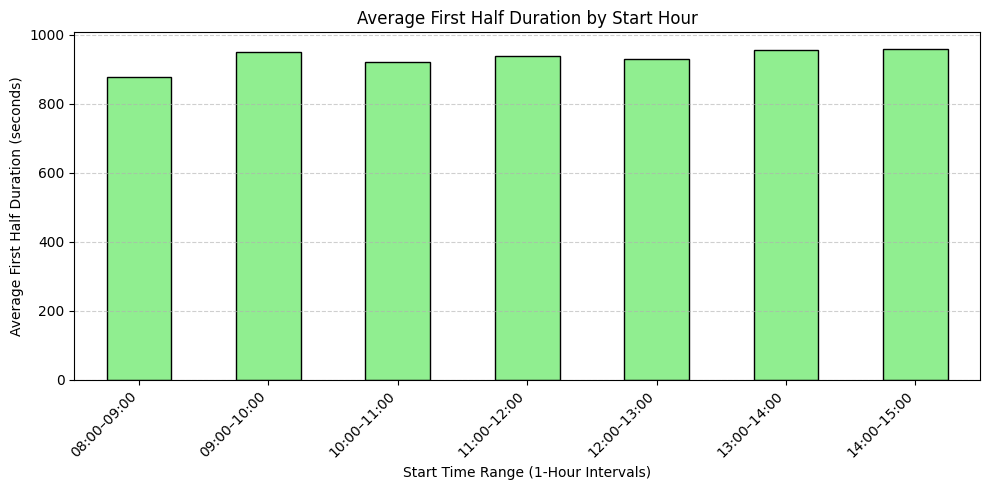

In [20]:
# Convert durations to timedelta for analysis/plotting
df_cycle_summary["_StartTimeTD"] = pd.to_timedelta(df_cycle_summary["StartTime"])
df_cycle_summary["_FirstHalfTD"] = pd.to_timedelta(df_cycle_summary["FirstHalfDuration"])
df_cycle_summary["_SecondHalfTD"] = pd.to_timedelta(df_cycle_summary["SecondHalfDuration"])
df_cycle_summary["_FullCycleTD"] = pd.to_timedelta(df_cycle_summary["FullCycleDuration"])


import matplotlib.pyplot as plt

# Group and average first half duration (in seconds)
avg_first_half = (
    df_cycle_summary
    .groupby("StartHourRange")["_FirstHalfTD"]
    .mean()
    .dropna()
    .sort_index()
    .dt.total_seconds()
)

# Plot
plt.figure(figsize=(10, 5))
avg_first_half.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.ylabel("Average First Half Duration (seconds)")
plt.xlabel("Start Time Range (1-Hour Intervals)")
plt.title("Average First Half Duration by Start Hour")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


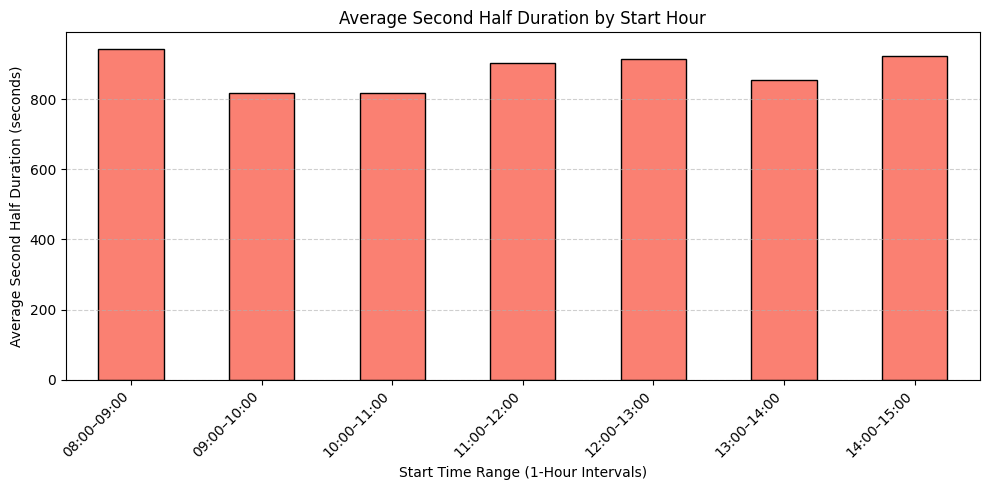

In [21]:
import matplotlib.pyplot as plt

# Group and average second half duration (in seconds)
avg_second_half = (
    df_cycle_summary
    .groupby("StartHourRange")["_SecondHalfTD"]
    .mean()
    .dropna()
    .sort_index()
    .dt.total_seconds()
)

# Plot
plt.figure(figsize=(10, 5))
avg_second_half.plot(kind="bar", color="salmon", edgecolor="black")
plt.ylabel("Average Second Half Duration (seconds)")
plt.xlabel("Start Time Range (1-Hour Intervals)")
plt.title("Average Second Half Duration by Start Hour")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipython-input-22-1396352025.py:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cycle_summary["ParsedDate"] = pd.to_datetime(df_cycle_summary["Date"], errors="coerce")


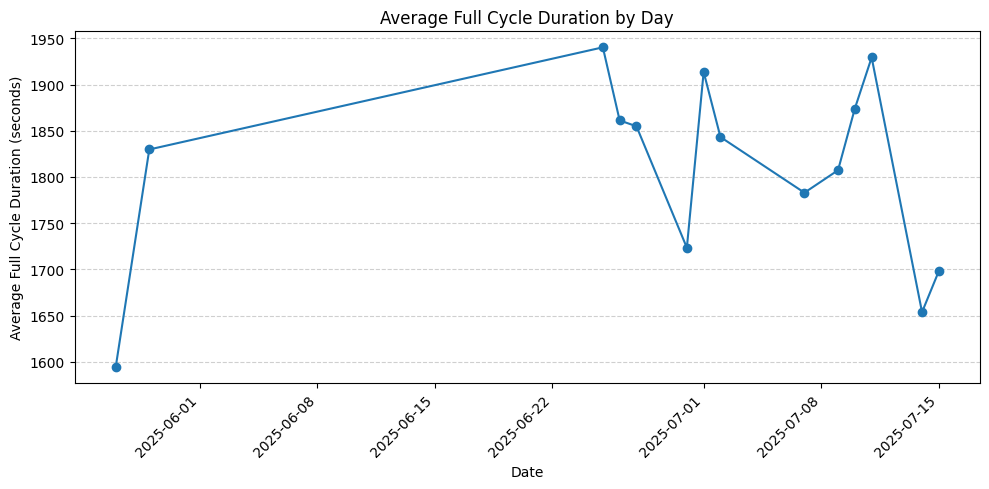

In [22]:
df_cycle_summary["_FullCycleTD"] = pd.to_timedelta(df_cycle_summary["FullCycleDuration"])


import matplotlib.pyplot as plt
import pandas as pd

# Ensure the Date column is in datetime format
df_cycle_summary["ParsedDate"] = pd.to_datetime(df_cycle_summary["Date"], errors="coerce")

# Group by day and compute average full cycle duration
avg_by_day = (
    df_cycle_summary
    .groupby("ParsedDate")["_FullCycleTD"]
    .mean()
    .dropna()
    .sort_index()
    .dt.total_seconds()
)

# Plot
plt.figure(figsize=(10, 5))
avg_by_day.plot(marker='o', linestyle='-')
plt.ylabel("Average Full Cycle Duration (seconds)")
plt.xlabel("Date")
plt.title("Average Full Cycle Duration by Day")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
